<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/Imad/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 311-Calls Clustering

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Function to read data from URL
def read_data_from_URL(url):
    df=pd.read_csv(url)
    return df

# Prepare Backup

In [3]:
# Backup Copy
serv_req_url='https://bitbucket.org/nthammad-uncc/knowledge_discovery_charlotte/raw/main/data/merged_requests.zip'
backup = read_data_from_URL(serv_req_url)

In [4]:
# Drop unneeded columns
backup.drop(columns=['Unnamed: 0', 'OBJECTID', 'DEPARTMENT', 'REQUEST_NO', 
                       'REQUEST_TYPE', 'RECEIVED_DATE', 'RECEIVED_MONTH', 'RECEIVED_YEAR', 
                       'SEASON', 'INTERNAL_FIELD_OBSERVATION', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 
                       'RECEIVED_DAY', 'ADDRESS_ID', 'EMPLOYED_All', 'PERCENT EMPLOYED_Not in labor force',
                       'PERCENT EMPLOYED_Female Only', 'COMMUTING TO WORK_All', 'PERCENT COMMUTING TO WORK_By Car',
                       'PERCENT COMMUTING TO WORK_Public transportation', 'PERCENT COMMUTING TO WORK_Walk', 
                       'PERCENT COMMUTING TO WORK_Other', 'PERCENT COMMUTING TO WORK_Worked at home', 
                       'INCOME AND BENEFITS_Total households', 'PERCENT HOUSEHOLD INCOME_Retired Householders'], inplace=True)

In [5]:
backup.head()

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,NON_RECYCLABLE ITEMS,215.0,3601.0,35.132444,-80.812089,15,0.000311,0.705954,0.213424,0.576240,0.210336,79300.428571,111885.642857,47529.928571,43332.642857,0.917971,0.082029,7.135714,NaN
1,UTILITY VERIFICATION LTR,265.0,4124.0,35.350408,-80.781941,10,0.000311,0.740375,0.241599,0.674026,0.084375,63391.250000,74852.450000,29914.900000,37226.300000,0.869184,0.130816,8.050000,NaN
2,NON_RECYCLABLE ITEMS,103.0,523.0,35.282654,-80.771094,7,0.002486,0.700170,0.462024,0.500445,0.037530,41973.411765,51723.764706,19338.294118,23576.882353,0.814082,0.185918,25.811765,NaN
3,MISSED SERVICE,158.0,1801.0,35.297745,-80.880327,21,0.002020,0.680489,0.393800,0.552855,0.053345,46401.066667,59119.666667,22976.800000,28399.600000,0.834642,0.165358,16.960000,NaN
4,CWP,88.0,309.0,35.254120,-80.877772,7,0.003730,0.720768,0.451759,0.497509,0.050732,42745.529412,53659.352941,23808.882353,29559.117647,0.825033,0.174967,20.682353,Y


In [6]:
# Drop NA's
backup = backup.dropna()

In [7]:
backup.shape

(161310, 19)

# The above 'backup' dataframe will be used to 
<br> (1) merge our 'labled' clusters (once we have run clustering)
<br> (2) plot the clusters

# Below: I am importing our 311 Dataset - will use this dataframe to cluster.

In [8]:
# Read in Naomi's merged, preprocessed data
serv_req_url='https://bitbucket.org/nthammad-uncc/knowledge_discovery_charlotte/raw/main/data/merged_requests.zip'
requests = read_data_from_URL(serv_req_url)
requests.head()

,Unnamed: 0,OBJECTID,DEPARTMENT,REQUEST_NO,REQUEST_CAT,REQUEST_TYPE,RECEIVED_DATE,RECEIVED_MONTH,RECEIVED_YEAR,SEASON,INTERNAL_FIELD_OBSERVATION,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE,RECEIVED_DAY,TOTAL_CALLS,ADDRESS_ID,CRIME_SCORE,EMPLOYED_All,PERCENT EMPLOYED_In labor force,PERCENT EMPLOYED_Not in labor force,PERCENT EMPLOYED_Female Only,COMMUTING TO WORK_All,PERCENT COMMUTING TO WORK_By Car,PERCENT COMMUTING TO WORK_Public transportation,PERCENT COMMUTING TO WORK_Walk,PERCENT COMMUTING TO WORK_Other,PERCENT COMMUTING TO WORK_Worked at home,INCOME AND BENEFITS_Total households,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,PERCENT HOUSEHOLD INCOME_Retired Householders,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,0,1,Solid Waste Services,6402056,NON_RECYCLABLE ITEMS,NON_RECYCLABLE ITEMS,2016-11-07 14:00:00,11,2016,4,N,215.0,3601.0,28226,1458251.0,508075.0,35.132444,-80.812089,2016-11-07,15,21882,0.000311,3571.000000,0.705954,0.294046,0.547692,2315.000000,0.867800,0.020731,0.014661,0.012267,0.084541,1852.928571,0.213424,0.576240,0.210336,0.157483,79300.428571,111885.642857,47529.928571,43332.642857,0.917971,0.082029,7.135714,NaN
1,1,2,Housing and NBHD Serv,6402064,UTILITY VERIFICATION LTR,UTILITY VERIFICATION LTR,2016-11-07 14:00:00,11,2016,4,N,265.0,4124.0,28269,1468687.0,587226.0,35.350408,-80.781941,2016-11-07,10,43252,0.000311,3877.600000,0.740375,0.259625,0.528438,2580.900000,0.895156,0.020414,0.007693,0.010918,0.065818,1925.100000,0.241599,0.674026,0.084375,0.129942,63391.250000,74852.450000,29914.900000,37226.300000,0.869184,0.130816,8.050000,NaN
2,2,3,Solid Waste Services,6402082,NON_RECYCLABLE ITEMS,NON_RECYCLABLE ITEMS,2016-11-07 14:00:00,11,2016,4,N,103.0,523.0,28213,1471481.0,562513.0,35.282654,-80.771094,2016-11-07,7,73999,0.002486,3095.470588,0.700170,0.299830,0.531391,1856.411765,0.885311,0.040584,0.029221,0.010399,0.034484,1308.647059,0.462024,0.500445,0.037530,0.113167,41973.411765,51723.764706,19338.294118,23576.882353,0.814082,0.185918,25.811765,NaN
3,3,4,Solid Waste Services,6402103,MISSED SERVICE,MISSED RECYCLING,2016-11-07 14:00:00,11,2016,4,N,158.0,1801.0,28216,1438992.0,568604.0,35.297745,-80.880327,2016-11-07,21,8430,0.002020,3548.600000,0.680489,0.319511,0.539649,2128.266667,0.865405,0.057418,0.021834,0.017391,0.037952,1645.333333,0.393800,0.552855,0.053345,0.128969,46401.066667,59119.666667,22976.800000,28399.600000,0.834642,0.165358,16.960000,NaN
4,4,6,Finance/City,6402112,CWP,CWP REQUEST,2016-11-07 14:00:00,11,2016,4,N,88.0,309.0,28208,1439454.0,552715.0,35.254120,-80.877772,2016-11-07,7,75771,0.003730,2972.444444,0.720768,0.279232,0.527302,1835.777778,0.812170,0.081005,0.039119,0.039021,0.028684,1481.222222,0.451759,0.497509,0.050732,0.097692,42745.529412,53659.352941,23808.882353,29559.117647,0.825033,0.174967,20.682353,Y


# **Set up the Requests Data Frame for Clustering**
## (1) Remove unwanted columns: like 'Department', 'Request_Type' <- We dont want our clustering to be biased.
Random: and how can we cluster based on a categorical column? 
## (2) Keep columns with numerical data

In [9]:
# Drop categorical columns 
requests.drop(columns=['Unnamed: 0', 'OBJECTID', 'DEPARTMENT', 'REQUEST_NO', 
                       'REQUEST_TYPE', 'RECEIVED_DATE', 'RECEIVED_MONTH', 'RECEIVED_YEAR', 
                       'SEASON', 'INTERNAL_FIELD_OBSERVATION', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 
                       'RECEIVED_DAY', 'ADDRESS_ID', 'EMPLOYED_All', 'PERCENT EMPLOYED_Not in labor force',
                       'PERCENT EMPLOYED_Female Only', 'COMMUTING TO WORK_All', 'PERCENT COMMUTING TO WORK_By Car',
                       'PERCENT COMMUTING TO WORK_Public transportation', 'PERCENT COMMUTING TO WORK_Walk', 
                       'PERCENT COMMUTING TO WORK_Other', 'PERCENT COMMUTING TO WORK_Worked at home', 
                       'INCOME AND BENEFITS_Total households', 'PERCENT HOUSEHOLD INCOME_Retired Householders'], inplace=True)




In [10]:
requests.head()

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,NON_RECYCLABLE ITEMS,215.0,3601.0,35.132444,-80.812089,15,0.000311,0.705954,0.213424,0.576240,0.210336,79300.428571,111885.642857,47529.928571,43332.642857,0.917971,0.082029,7.135714,NaN
1,UTILITY VERIFICATION LTR,265.0,4124.0,35.350408,-80.781941,10,0.000311,0.740375,0.241599,0.674026,0.084375,63391.250000,74852.450000,29914.900000,37226.300000,0.869184,0.130816,8.050000,NaN
2,NON_RECYCLABLE ITEMS,103.0,523.0,35.282654,-80.771094,7,0.002486,0.700170,0.462024,0.500445,0.037530,41973.411765,51723.764706,19338.294118,23576.882353,0.814082,0.185918,25.811765,NaN
3,MISSED SERVICE,158.0,1801.0,35.297745,-80.880327,21,0.002020,0.680489,0.393800,0.552855,0.053345,46401.066667,59119.666667,22976.800000,28399.600000,0.834642,0.165358,16.960000,NaN
4,CWP,88.0,309.0,35.254120,-80.877772,7,0.003730,0.720768,0.451759,0.497509,0.050732,42745.529412,53659.352941,23808.882353,29559.117647,0.825033,0.174967,20.682353,Y


## Removing: Block_NO, Neighborhood_Profile_Area because the clustering might be biased towards 'areas' with higher counts?

In [11]:
# Drop the other columns 11-16
requests.drop(requests.columns[[11, 12, 13, 14, 15, 16]], axis = 1, inplace = True)

In [12]:
requests.head()

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,NON_RECYCLABLE ITEMS,215.0,3601.0,35.132444,-80.812089,15,0.000311,0.705954,0.213424,0.576240,0.210336,7.135714,NaN
1,UTILITY VERIFICATION LTR,265.0,4124.0,35.350408,-80.781941,10,0.000311,0.740375,0.241599,0.674026,0.084375,8.050000,NaN
2,NON_RECYCLABLE ITEMS,103.0,523.0,35.282654,-80.771094,7,0.002486,0.700170,0.462024,0.500445,0.037530,25.811765,NaN
3,MISSED SERVICE,158.0,1801.0,35.297745,-80.880327,21,0.002020,0.680489,0.393800,0.552855,0.053345,16.960000,NaN
4,CWP,88.0,309.0,35.254120,-80.877772,7,0.003730,0.720768,0.451759,0.497509,0.050732,20.682353,Y


# Cont. removing columns

In [13]:
# Drop the other columns 0-3
requests.drop(requests.columns[[0, 1, 2, 3, 4]], axis = 1, inplace = True)

In [14]:
requests.head()

,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,15,0.000311,0.705954,0.213424,0.576240,0.210336,7.135714,NaN
1,10,0.000311,0.740375,0.241599,0.674026,0.084375,8.050000,NaN
2,7,0.002486,0.700170,0.462024,0.500445,0.037530,25.811765,NaN
3,21,0.002020,0.680489,0.393800,0.552855,0.053345,16.960000,NaN
4,7,0.003730,0.720768,0.451759,0.497509,0.050732,20.682353,Y


# The columns left are all numeric (except Redlining)
# Need to Standardize the Total_Calls column

In [15]:
# Need to standardize Total_Calls
from sklearn.preprocessing import StandardScaler
requests[['TOTAL_CALLS']] = StandardScaler().fit_transform(requests[['TOTAL_CALLS']])


In [16]:
requests.head() 

,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING
0,-0.158456,0.000311,0.705954,0.213424,0.576240,0.210336,7.135714,NaN
1,-0.270466,0.000311,0.740375,0.241599,0.674026,0.084375,8.050000,NaN
2,-0.337671,0.002486,0.700170,0.462024,0.500445,0.037530,25.811765,NaN
3,-0.024045,0.002020,0.680489,0.393800,0.552855,0.053345,16.960000,NaN
4,-0.337671,0.003730,0.720768,0.451759,0.497509,0.050732,20.682353,Y


In [17]:
# Drop NA's
requests = requests.dropna()

In [18]:
requests.shape

(161310, 8)

# Trying KPROTOTYPES Clustering
## This will allow us to use Categorical Data in our Clustering

In [19]:
# Install kmodes
! pip install kmodes
 

In [20]:
from kmodes.kprototypes import KPrototypes 

In [21]:
# Step 1: Covert df into a numpy array
df_array = requests.values 

In [22]:
# Step 2: Define which columns are supposed to be numeric
df_array[:, 0] = df_array[:, 0].astype(float) 
df_array[:, 1] = df_array[:, 1].astype(float) 
df_array[:, 2] = df_array[:, 2].astype(float) 
df_array[:, 3] = df_array[:, 3].astype(float) 
df_array[:, 4] = df_array[:, 4].astype(float) 
df_array[:, 5] = df_array[:, 5].astype(float) 
df_array[:, 6] = df_array[:, 6].astype(float) 



In [23]:
# Step 3: Setup the model

kproto = KPrototypes(n_clusters = 5,
                     max_iter = 5)

clusters = kproto.fit_predict(df_array, categorical = [7])

In [24]:
# Print Clusters
print(kproto.cluster_centroids_)

[['-0.019158880345890406' '0.007461304792995933' '0.7643053177553365'
  '0.20271084713525908' '0.5068943063558078' '0.2903948465088531'
  '10.17675213639048' 'B']
 ['0.024880609777723574' '0.0051192097911501415' '0.7086373189503756'
  '0.32881089478784914' '0.5407424677841973' '0.1304466374279377'
  '14.47953446275438' 'R']
 ['-0.050153804065176326' '0.00537584160697213' '0.6923443648282661'
  '0.4795819659936646' '0.4472346237688714' '0.07318341023740048'
  '23.845266755346763' 'Y']
 ['-0.052138249181684' '0.003638607036672907' '0.7187362248610593'
  '0.4506906296350469' '0.47952078052532904' '0.06978858983955685'
  '20.374801504442967' 'Y']
 ['-0.01042880694949341' '0.002808404323833766' '0.7395676885279614'
  '0.4029326722260539' '0.519437958388099' '0.0776293693853888'
  '17.62419426453302' 'Y']]


# We have our Clusters - Now we can add these values back to our 'Backup' dataframe

In [25]:
# Attach Clusters to the Backup DF

cluster_dict = []
for c in clusters:
  cluster_dict.append(c)

In [ ]:
# View the dictionary
cluster_dict

In [27]:
# Assign Cluster Dictionary Back to Original DF
backup['cluster'] = cluster_dict

In [28]:
# Double check if we have added clusters to the original data
backup.head()

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING,cluster
4,CWP,88.0,309.0,35.254120,-80.877772,7,0.003730,0.720768,0.451759,0.497509,0.050732,42745.529412,53659.352941,23808.882353,29559.117647,0.825033,0.174967,20.682353,Y,3
19,NON_RECYCLABLE ITEMS,386.0,1015.0,35.237288,-80.807337,5,0.001990,0.747104,0.436481,0.494893,0.068627,45000.130435,59457.956522,26401.173913,28324.217391,0.776592,0.223408,19.469565,Y,3
64,BULKY ITEM,386.0,1836.0,35.234153,-80.809887,18,0.001990,0.747104,0.436481,0.494893,0.068627,45000.130435,59457.956522,26401.173913,28324.217391,0.776592,0.223408,19.469565,Y,3
68,TIRES,37.0,1521.0,35.231663,-80.816705,18,0.004797,0.747104,0.436481,0.494893,0.068627,45000.130435,59457.956522,26401.173913,28324.217391,0.776592,0.223408,19.469565,Y,3
81,WEATHER AND ENVIRONMENTAL,367.0,325.0,35.214877,-80.823880,2,0.008270,0.757902,0.288506,0.497652,0.213842,72715.555556,108829.777778,56907.444444,49571.555556,0.922552,0.077448,14.533333,Y,1


In [29]:
# Take a look at Cluster 0
c_0 = backup[backup['cluster'] == 0]
c_0.head(10)

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING,cluster
118,RECYCLING,3.0,1904.0,35.202458,-80.847938,9,0.013644,0.810697,0.240830,0.548064,0.211106,75988.375000,112120.500000,60731.250000,53428.625000,0.930831,0.069169,11.887500,B,0
127,NON_RECYCLABLE ITEMS,364.0,1524.0,35.186551,-80.820623,20,0.001706,0.708485,0.210457,0.439707,0.349836,112769.333333,178395.833333,75177.166667,62032.166667,0.938898,0.061102,9.866667,B,0
171,NON_RECYCLABLE ITEMS,392.0,2109.0,35.186690,-80.837929,3,0.006065,0.705189,0.187603,0.450639,0.361758,120704.333333,192392.333333,81175.000000,66888.500000,0.934164,0.065836,9.133333,G,0
225,TRANSPORTATION,3.0,2421.0,35.202842,-80.862478,19,0.013644,0.810697,0.240830,0.548064,0.211106,75988.375000,112120.500000,60731.250000,53428.625000,0.930831,0.069169,11.887500,B,0
280,NON_RECYCLABLE ITEMS,3.0,728.0,35.214293,-80.847272,4,0.013644,0.810697,0.240830,0.548064,0.211106,75988.375000,112120.500000,60731.250000,53428.625000,0.930831,0.069169,11.887500,B,0
380,MISSED SERVICE,392.0,222.0,35.206781,-80.824343,10,0.002814,0.727185,0.249571,0.554783,0.195645,74261.266667,107661.466667,46863.800000,44388.533333,0.875747,0.124253,10.273333,G,0
522,CART,3.0,2301.0,35.201379,-80.857157,14,0.017210,0.809473,0.215270,0.558648,0.226082,81175.875000,118292.750000,63064.375000,55744.000000,0.944432,0.055568,10.925000,B,0
524,NON_RECYCLABLE ITEMS,388.0,2027.0,35.214082,-80.869569,27,0.002459,0.809473,0.215270,0.558648,0.226082,81175.875000,118292.750000,63064.375000,55744.000000,0.944432,0.055568,10.925000,Y,0
571,RECYCLABLE ITEMS,388.0,2204.0,35.212930,-80.868032,3,0.002459,0.809473,0.215270,0.558648,0.226082,81175.875000,118292.750000,63064.375000,55744.000000,0.944432,0.055568,10.925000,Y,0
648,NON_RECYCLABLE ITEMS,364.0,1645.0,35.185280,-80.818656,4,0.001803,0.705189,0.187603,0.450639,0.361758,120704.333333,192392.333333,81175.000000,66888.500000,0.934164,0.065836,9.133333,B,0


In [30]:
# Take a look at Cluster 1
c_1 = backup[backup['cluster'] == 1]
c_1.head(10)

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING,cluster
81,WEATHER AND ENVIRONMENTAL,367.0,325.0,35.214877,-80.823880,2,0.008270,0.757902,0.288506,0.497652,0.213842,72715.555556,108829.777778,56907.444444,49571.555556,0.922552,0.077448,14.533333,Y,1
120,NON_RECYCLABLE ITEMS,85.0,2801.0,35.261537,-80.862286,19,0.004406,0.685791,0.370274,0.565565,0.064161,49231.000000,61789.066667,24375.466667,30075.533333,0.842697,0.157303,15.186667,R,1
174,NON_RECYCLABLE ITEMS,163.0,205.0,35.214778,-80.832796,125,0.002459,0.734846,0.232150,0.465533,0.302316,72935.333333,114527.666667,60070.555556,52855.222222,0.936432,0.063568,12.070000,R,1
178,NON_RECYCLABLE ITEMS,85.0,2921.0,35.260824,-80.865382,36,0.002814,0.685791,0.370274,0.565565,0.064161,49231.000000,61789.066667,24375.466667,30075.533333,0.842697,0.157303,15.186667,R,1
180,CART,392.0,2538.0,35.177585,-80.836298,1,0.002814,0.744506,0.302961,0.517167,0.179871,68583.363636,103494.545455,47771.909091,45541.818182,0.889115,0.110885,15.200000,G,1
183,HNS HEALTH AND SANITATION,85.0,2708.0,35.259332,-80.860932,5,0.002814,0.685791,0.370274,0.565565,0.064161,49231.000000,61789.066667,24375.466667,30075.533333,0.842697,0.157303,15.186667,R,1
212,NON_RECYCLABLE ITEMS,367.0,712.0,35.220938,-80.821526,9,0.008101,0.757902,0.288506,0.497652,0.213842,72715.555556,108829.777778,56907.444444,49571.555556,0.922552,0.077448,14.533333,Y,1
248,RECYCLABLE ITEMS,367.0,2017.0,35.213965,-80.815366,9,0.006961,0.757902,0.288506,0.497652,0.213842,72715.555556,108829.777778,56907.444444,49571.555556,0.922552,0.077448,14.533333,Y,1
298,NON_RECYCLABLE ITEMS,392.0,1649.0,35.188693,-80.842119,5,0.003553,0.744506,0.302961,0.517167,0.179871,68583.363636,103494.545455,47771.909091,45541.818182,0.889115,0.110885,15.200000,G,1
331,CART,392.0,345.0,35.177123,-80.844803,9,0.002646,0.744506,0.302961,0.517167,0.179871,68583.363636,103494.545455,47771.909091,45541.818182,0.889115,0.110885,15.200000,G,1


In [31]:
# Cluster 2 Data
c_2 = backup[backup['cluster'] == 2]

In [32]:
# Cluster 3 Data
c_3 = backup[backup['cluster'] == 3]

In [33]:
# Cluster 4 Data
c_4 = backup[backup['cluster'] == 4]

# Visualize Clusters on our ShapeFile

In [34]:
! pip install geopandas
import geopandas as gpd

! pip install contextily
import contextily as ctx


In [35]:
# mount and connect my drive to access shape files 

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
# IMPORT SHAPE FILE FOR MAPPING
npa_map = gpd.read_file('/content/gdrive/MyDrive/Charlotte 311 Calls Project/Data/NPA/npa.shp')

# Layers into a web mercator projection
# reproject to web mercator
npa_map = npa_map.to_crs(epsg=4326)

In [37]:
# Turn our Backup Data Frame into a GeoPandas Data Frame

geo_requests = gpd.GeoDataFrame(backup, 
                                crs = 'EPSG:4326',
                                geometry = gpd.points_from_xy(backup.LONGITUDE, 
                                                              backup.LATITUDE))

In [38]:
# Confirm reproject to CRS = EPSG 4326 (Map with Long/Lat)
geo_requests = geo_requests.to_crs(epsg=4326)

In [39]:
# convert lat/lon to floats
geo_requests.LONGITUDE = geo_requests.LONGITUDE.astype('float')
geo_requests.LATITUDE = geo_requests.LATITUDE.astype('float')

In [40]:
# drop the unmapped rows - anything that has a longitude of 0 should be removed
geo_requests = geo_requests[geo_requests.LONGITUDE!=0]
geo_requests = geo_requests[geo_requests.LATITUDE!=0]

In [41]:
# get the bounding box coordinates for the 311 calls data
minx, miny, maxx, maxy = geo_requests.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-85.56829116
-80.77474209
35.16855221
35.27547993


In [42]:
# get the bounding box coordinates for the SHAPE FILE calls data
minx, miny, maxx, maxy = npa_map.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-81.05802900022775
-80.55029699963121
35.00171000120846
35.51510300167768


In [43]:
# Filter Cluster Data 

# Cluster 0
cluster0 = geo_requests[geo_requests['cluster'] == 0]

# Cluster 1
cluster1 = geo_requests[geo_requests['cluster'] == 1]

# Cluster 2
cluster2 = geo_requests[geo_requests['cluster'] == 2]

# Cluster 3
cluster3 = geo_requests[geo_requests['cluster'] == 3]

# Cluster 4
cluster4 = geo_requests[geo_requests['cluster'] == 4]

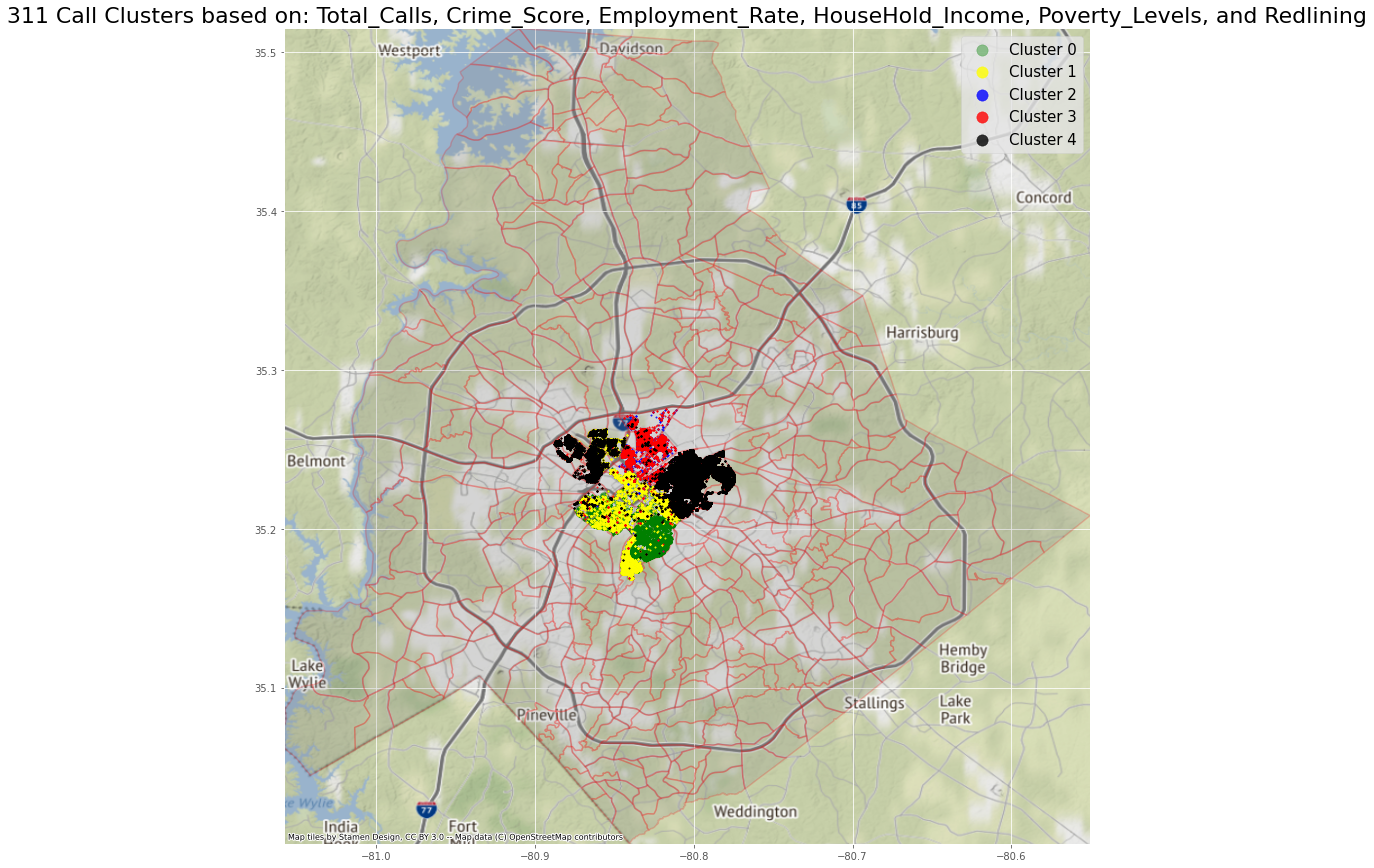

In [44]:
# Plot Clusters
fig, ax = plt.subplots(figsize=(15,15))

# Plots 1: Background Map
npa_map.plot(ax=ax,
             color='grey', 
             edgecolor='red',
             lw=1.5,
             alpha=0.2)

# Plot 2: Cluster Zero
cluster0.plot(ax=ax, 
              color='green',
              markersize=2,
              alpha=0.4,
              label = 'Cluster 0')

# Plot 3: Cluster One
cluster1.plot(ax=ax, 
              color='yellow',
              markersize=2,
              alpha=0.8,
              label = 'Cluster 1')

# Plot 4: Cluster Two
cluster2.plot(ax=ax, 
              color='blue',
              markersize=2,
              alpha=0.8,
              label = 'Cluster 2')

# Plot 5: Cluster Three
cluster3.plot(ax=ax, 
              color='red',
              markersize=2,
              alpha=0.8,
              label = 'Cluster 3')

# Plot 6: Cluster Four
cluster4.plot(ax=ax, 
              color='black',
              markersize=2,
              alpha=0.8,
              label = 'Cluster 4')

plt.legend(markerscale = 8,
           prop={'size': 15})

# Use the bouding coordinates to set the x and y limits
ax.set_xlim(minx, maxx) 
ax.set_ylim(miny, maxy)

# no axis
# ax.axis('off')
ax.set_title('311 Call Clusters based on: Total_Calls, Crime_Score, Employment_Rate, HouseHold_Income, Poverty_Levels, and Redlining',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = npa_map.crs.to_string())

# WHAT IF 
# WE Cluster based only on TOTAL_CALLS

In [45]:
# Create New Requests DF
serv_req_url='https://bitbucket.org/nthammad-uncc/knowledge_discovery_charlotte/raw/main/data/merged_requests.zip'
requests1 = read_data_from_URL(serv_req_url)

In [46]:
# Drop NA's
requests1 = requests1.dropna()

In [47]:
# Remove all columns except Total_Calls
total_calls_subset = requests1[['TOTAL_CALLS']]

In [48]:
total_calls_subset.head()

,TOTAL_CALLS
4,7
19,5
64,18
68,18
81,2


In [49]:
# Standardize Total_Calls
from sklearn.preprocessing import StandardScaler
total_calls_subset[['TOTAL_CALLS']] = StandardScaler().fit_transform(total_calls_subset[['TOTAL_CALLS']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [50]:
# Cluster

from sklearn.cluster import KMeans

# Step 1: Covert df into a numpy array
df_array1 = total_calls_subset.values 


# Step 2: Define which columns are supposed to be numeric
df_array1[:, 0] = df_array1[:, 0].astype(float) 

# Step 3: Setup the model
kmeans = KMeans(init="random",
                n_clusters = 5,
                n_init = 10,
                max_iter = 20,
                random_state=42
                )

clusters = kmeans.fit_predict(df_array1)


In [51]:
# Cluster Centeroids
kmeans.cluster_centers_

array([[ 2.82384169e+00],
       [ 8.98211057e-01],
       [-3.68020869e-01],
       [ 5.84694569e+00],
       [-4.86843188e-03]])

In [52]:
# Create a Cluster Dictionary
cluster_dict1 = []
for c in clusters:
  cluster_dict1.append(c)

In [53]:
# Add these cluster dictionary back to georequests ---> as 'cluster 1' which will stand for 'clusters based on total_calls'
geo_requests['cluster1'] = cluster_dict1

In [54]:
geo_requests.head()

,REQUEST_CAT,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,LATITUDE,LONGITUDE,TOTAL_CALLS,CRIME_SCORE,PERCENT EMPLOYED_In labor force,PERCENT HOUSEHOLD INCOME_Lower Income Households,PERCENT HOUSEHOLD INCOME_Mid Income Households,PERCENT HOUSEHOLD INCOME_Higher Income Households,INCOME AND BENEFITS_Median households income (dollars),INCOME AND BENEFITS_Mean households income (dollars),INCOME AND BENEFITS_Per capita Income,INCOME AND BENEFITS_Median earnings for workers (dollars),PERCENT INSURED_Population with health insurance,PERCENT INSURED_Population without health insurance,PERCENTAGE BELOW POVERTY LEVEL_All,HISTORIC_REDLINING,cluster,geometry,cluster1
4,CWP,88.0,309.0,35.254120,-80.877772,7,0.003730,0.720768,0.451759,0.497509,0.050732,42745.529412,53659.352941,23808.882353,29559.117647,0.825033,0.174967,20.682353,Y,3,POINT (-80.87777 35.25412),2
19,NON_RECYCLABLE ITEMS,386.0,1015.0,35.237288,-80.807337,5,0.001990,0.747104,0.436481,0.494893,0.068627,45000.130435,59457.956522,26401.173913,28324.217391,0.776592,0.223408,19.469565,Y,3,POINT (-80.80734 35.23729),2
64,BULKY ITEM,386.0,1836.0,35.234153,-80.809887,18,0.001990,0.747104,0.436481,0.494893,0.068627,45000.130435,59457.956522,26401.173913,28324.217391,0.776592,0.223408,19.469565,Y,3,POINT (-80.80989 35.23415),4
68,TIRES,37.0,1521.0,35.231663,-80.816705,18,0.004797,0.747104,0.436481,0.494893,0.068627,45000.130435,59457.956522,26401.173913,28324.217391,0.776592,0.223408,19.469565,Y,3,POINT (-80.81670 35.23166),4
81,WEATHER AND ENVIRONMENTAL,367.0,325.0,35.214877,-80.823880,2,0.008270,0.757902,0.288506,0.497652,0.213842,72715.555556,108829.777778,56907.444444,49571.555556,0.922552,0.077448,14.533333,Y,1,POINT (-80.82388 35.21488),2


In [55]:
# Filter 'Cluster1' Data
# tc stats for total_calls

# Cluster 0
tc_cluster0 = geo_requests[geo_requests['cluster1'] == 0]

# Cluster 1
tc_cluster1 = geo_requests[geo_requests['cluster1'] == 1]

# Cluster 2
tc_cluster2 = geo_requests[geo_requests['cluster1'] == 2]

# Cluster 3
tc_cluster3 = geo_requests[geo_requests['cluster1'] == 3]

# Cluster 4
tc_cluster4 = geo_requests[geo_requests['cluster1'] == 4]

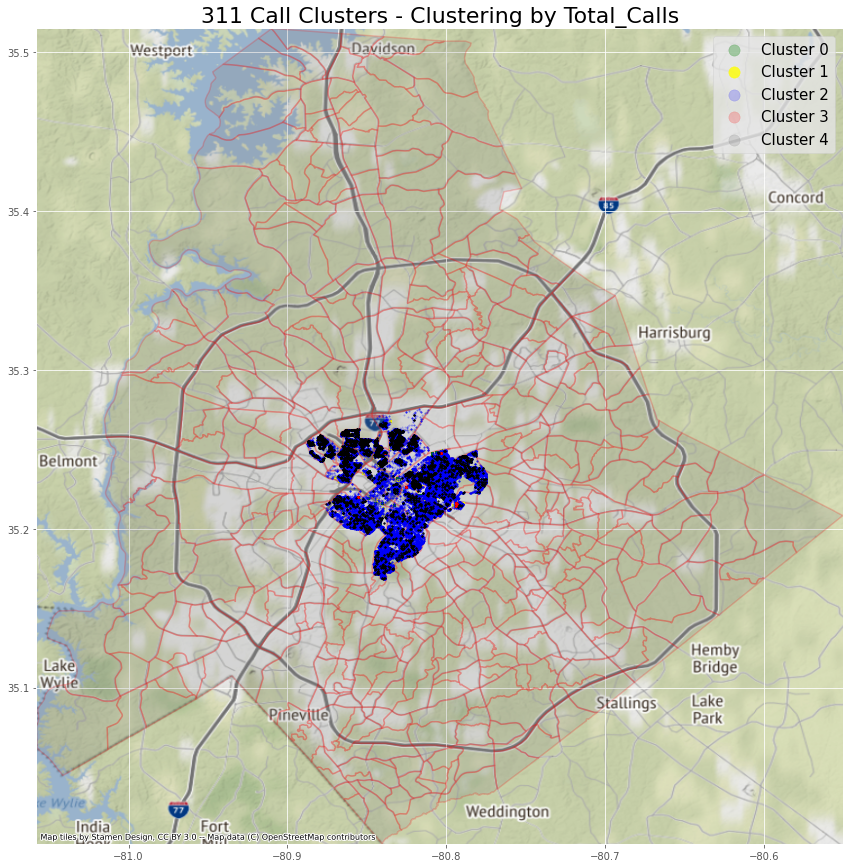

In [56]:
# Plot Clusters based on Total_Calls
fig, ax = plt.subplots(figsize=(15,15))

# Plots 1: Background Map
npa_map.plot(ax=ax,
             color='grey', 
             edgecolor='red',
             lw=1.5,
             alpha=0.2)

# Plot 2: Cluster Zero
tc_cluster0.plot(ax=ax, 
                  color='green',
                  markersize=2,
                  alpha=0.3,
                  label = 'Cluster 0')

# Plot 3: Cluster One
tc_cluster1.plot(ax=ax, 
                  color='yellow',
                  markersize=2,
                  alpha=0.8,
                  label = 'Cluster 1')

# Plot 4: Cluster Two
tc_cluster2.plot(ax=ax, 
                  color='blue',
                  markersize=2,
                  alpha=0.2,
                  label = 'Cluster 2')

# Plot 5: Cluster Three
tc_cluster3.plot(ax=ax, 
                  color='red',
                  markersize=2,
                  alpha=0.2,
                  label = 'Cluster 3')

# Plot 6: Cluster Four
tc_cluster4.plot(ax=ax, 
                  color='black',
                  markersize=2,
                  alpha=0.1,
                  label = 'Cluster 4')

plt.legend(markerscale = 8,
           prop={'size': 15})

# Use the bouding coordinates to set the x and y limits
ax.set_xlim(minx, maxx) 
ax.set_ylim(miny, maxy)

# no axis
# ax.axis('off')
ax.set_title('311 Call Clusters - Clustering by Total_Calls',fontsize=22)

# add a basemap
ctx.add_basemap(ax, crs = npa_map.crs.to_string())